In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
sns.set()

In [16]:
df=pd.read_csv("train-HR.csv")
df.index = df.EmployeeNumber
df.head()
print("Shape: ", df.shape)
#df.columns

Shape:  (1322, 32)


In [17]:
predictor = df[['Age', 'Gender', 'Department', 'JobRole', 'JobLevel',
       'JobSatisfaction', 'JobInvolvement', 'PerformanceRating', 'OverTime',
       'EnvironmentSatisfaction', 'EducationField', 'Education',
       'BusinessTravel', 'WorkLifeBalance', 'MaritalStatus',
       'RelationshipSatisfaction', 'DistanceFromHome', 'StockOptionLevel',
       'NumCompaniesWorked', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'DailyRate', 'HourlyRate', 'MonthlyIncome',
       'MonthlyRate', 'PercentSalaryHike']]

target = df['Attrition']


In [18]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(predictor, target,test_size=0.2,random_state=0)
print("Shape of training data: ",train_x.shape)
print("Shape of test data: ",train_y.shape)

Shape of training data:  (1057, 30)
Shape of test data:  (1057,)


### Hyperparameter Tuning

In [19]:
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [20]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( train_x, train_y), ( test_x, test_y)]
    
    clf.fit(train_x, train_y,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(test_x)
    accuracy = accuracy_score(test_y, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [21]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                                                                 
0.8415094339622642                                                                                                     
SCORE:                                                                                                                 
0.8415094339622642                                                                                                     
SCORE:                                                                                                                 
0.8415094339622642                                                                                                     
SCORE:                                                                                                                 
0.8415094339622642                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.8415094339622642                                                                                                     
SCORE:                                                                                                                 
0.8415094339622642                                                                                                     
SCORE:                                                                                                                 
0.8415094339622642                                                                                                     
SCORE:                                                                                                                 
0.8415094339622642                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.8415094339622642                                                                                                     
SCORE:                                                                                                                 
0.8415094339622642                                                                                                     
SCORE:                                                                                                                 
0.8415094339622642                                                                                                     
SCORE:                                                                                                                 
0.8415094339622642                                                                                                     
SCORE:                                  

In [22]:
print("The best hyperparameters are ","\n")
print(best_hyperparams)

The best hyperparameters are  

{'colsample_bytree': 0.6536555651994, 'gamma': 5.775981335020807, 'max_depth': 17.0, 'min_child_weight': 4.0, 'reg_alpha': 100.0, 'reg_lambda': 0.8847852026582983}


In [23]:
clf = Pipeline(steps=[('scalar', StandardScaler()),
                      ('classifier', XGBClassifier(colsample_bytree= 0.9805673476641286, 
                                                   gamma= 8.5794981092432, 
                                                   max_depth= 14, 
                                                   min_child_weight= 5.0, 
                                                   reg_alpha= 102.0, 
                                                   reg_lambda= 0.03588896779560902))])
clf.fit(train_x,train_y)
predictions = clf.predict(train_x)
predict_test  = clf.predict(test_x)

print('RMSE on train data: ')
print(np.sqrt(np.mean(predictions- train_y)**2))
print('RMSE on test data: ')
print(np.sqrt(np.mean(predict_test- test_y)**2))


C:\Users\navvu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMSE on train data: 
0.1665089877010407
RMSE on test data: 
0.15849056603773584


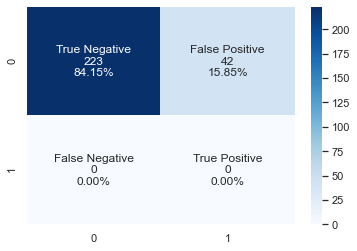

In [24]:
cf_matrix = confusion_matrix(predict_test, test_y)

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

This is a case of overfitting; the model trains well for the training set however shows error for the validation set

In [25]:
# For the validation set

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: ",accuracy_score(test_y, predict_test))

# Recall
from sklearn.metrics import recall_score
print("Recall: ",recall_score(test_y, predict_test, average=None)[0])

# Precision
from sklearn.metrics import precision_score
print("Precision: ",precision_score(test_y, predict_test, average=None)[0])

#F1-score
from sklearn.metrics import f1_score
print("F1 score: ",f1_score(test_y, predict_test, average=None)[0])

Accuracy:  0.8415094339622642
Recall:  1.0
Precision:  0.8415094339622642
F1 score:  0.9139344262295083


C:\Users\navvu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Testing the model

In [26]:
test_df=pd.read_csv("test-HR.csv")
test_df.index = test_df.EmployeeNumber
print("Shape",test_df.shape)
test_df.head()

test_predictor = test_df.drop(['EmployeeNumber','Attrition'],1)
test_target = test_df.Attrition
test_predictor

Shape (148, 32)


,Age,Gender,Department,JobRole,JobLevel,JobSatisfaction,JobInvolvement,PerformanceRating,OverTime,EnvironmentSatisfaction,...,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,DailyRate,HourlyRate,MonthlyIncome,MonthlyRate,PercentSalaryHike
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1857,46,1,2,5,3,4,3,3,0,4,...,4,9,8,4,7,706,82,8578,19989,14
1858,28,1,1,2,1,4,3,3,0,3,...,2,3,2,2,2,280,43,2706,10494,15
1859,29,1,2,1,2,3,1,3,0,4,...,3,7,0,1,6,726,93,6384,21143,17
1860,42,1,2,3,1,3,3,3,0,4,...,3,0,0,0,0,1142,81,3968,13624,13
1862,32,1,3,8,2,2,2,3,1,3,...,3,2,2,2,2,414,82,9907,26186,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,36,1,2,3,2,4,4,3,0,3,...,3,5,2,0,3,884,41,2571,12290,17
2062,39,1,2,1,3,1,2,3,0,4,...,5,7,7,1,7,613,42,9991,21457,15
2064,27,1,2,5,2,2,4,4,1,2,...,0,6,2,0,3,155,87,6142,5174,20


In [27]:
y_predict = clf.predict(test_predictor)

print('RMSE on test data: ')
print(np.sqrt(np.mean(y_predict- test_target)**2))

RMSE on test data: 
0.12837837837837837


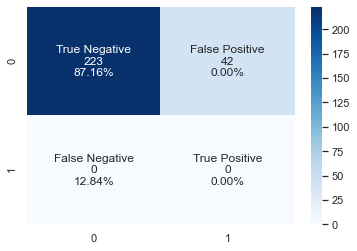

In [28]:
test_matrix = confusion_matrix(test_target, y_predict)

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     test_matrix.flatten()/np.sum(test_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [29]:
# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: ",accuracy_score(test_target, y_predict))

# Recall
from sklearn.metrics import recall_score
print("Recall: ",recall_score(test_target, y_predict, average=None)[0])

# Precision
from sklearn.metrics import precision_score
print("Precision: ",precision_score(test_target, y_predict, average=None)[0])

#F1-score
from sklearn.metrics import f1_score
print("F1 score: ",f1_score(test_target, y_predict, average=None)[0])

Accuracy:  0.8716216216216216
Recall:  1.0
Precision:  0.8716216216216216
F1 score:  0.9314079422382672


C:\Users\navvu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Using values reduced by PCA to optimise the accuracy

In [30]:
pca_train = pd.read_csv("../HR_Attrition_Project/pca-train-HR.csv")
pca_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.409064,0.160680,-1.716593,1.830294,1.016328,0.238033,2.718494,-0.895283,-0.162141,0.916786,...,-0.468599,-0.466730,1.122643,-0.882822,1.094624,1.638283,-0.242344,-0.792473,0.268079,-0.384488
1,0.563592,-1.146969,2.898770,0.670695,-0.050051,0.983238,-0.276628,-0.291559,1.551159,0.088934,...,0.992271,0.088657,-1.322833,-0.936052,0.377191,0.192314,-1.993617,0.239492,0.016443,0.654156
2,-2.479954,1.221133,-0.328731,0.879818,-1.236178,0.763653,-0.474335,1.489637,-1.725145,0.023501,...,-0.967976,1.441390,0.020097,-0.296363,-0.110701,1.489248,0.036140,0.113525,0.368877,-0.371208
3,-0.875964,-0.522983,-1.326795,-0.097936,-0.433541,1.434501,1.367728,1.079565,0.628383,1.816440,...,-1.156882,0.284579,-0.471482,-0.532564,-1.410697,-0.265560,0.175595,0.449356,-0.971498,0.295738
4,-1.850810,1.260646,-0.592262,-0.491348,-0.963587,-0.213744,-1.271774,0.146525,-0.389915,-0.247538,...,1.057911,-2.265619,0.187929,-0.714792,0.393703,2.191209,0.776645,-0.625789,0.266285,-0.373826


In [31]:
pca_train_x, test_x, pca_train_y, test_y = train_test_split(pca_train, target,test_size=0.2,random_state=0)
print("Shape of training data: ",pca_train_x.shape)
print("Shape of test data: ",pca_train_y.shape)

Shape of training data:  (1057, 25)
Shape of test data:  (1057,)


In [32]:
clf = Pipeline(steps=[('scalar', StandardScaler()),
                      ('classifier', XGBClassifier())])
clf.fit(pca_train_x,pca_train_y)
predictions = clf.predict(pca_train_x)
predict_test  = clf.predict(test_x)

print('RMSE on train data: ')
print(np.sqrt(np.mean(predictions- pca_train_y)**2))
print('RMSE on test data: ')
print(np.sqrt(np.mean(predict_test- test_y)**2))

C:\Users\navvu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMSE on train data: 
0.0
RMSE on test data: 
0.09811320754716982


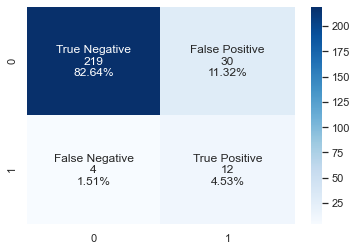

In [33]:


cf_matrix = confusion_matrix(predict_test, test_y)

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Blues")

In [34]:
# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: ",accuracy_score(test_y, predict_test))

# Recall
from sklearn.metrics import recall_score
print("Recall: ",recall_score(test_y, predict_test, average=None)[0])

# Precision
from sklearn.metrics import precision_score
print("Precision: ",precision_score(test_y, predict_test, average=None)[0])

#F1-score
from sklearn.metrics import f1_score
print("F1 score: ",f1_score(test_y, predict_test, average=None)[0])


Accuracy:  0.8716981132075472
Recall:  0.9820627802690582
Precision:  0.8795180722891566
F1 score:  0.9279661016949152


In [35]:
test_pca=pd.read_csv("pca-test-HR.csv")
print("Shape of train data: ",test_pca.shape)
test_pca.head()

test_df=pd.read_csv("test-HR.csv")
test_pca_target = test_df.Attrition
print("Shape of test data: ",test_pca.shape)

Shape of train data:  (148, 25)
Shape of test data:  (148, 25)


In [36]:
y_pca_predict = clf.predict(test_pca)

print('RMSE on train data: ')
print(np.sqrt(np.mean(y_pca_predict- test_pca_target)**2))

RMSE on train data: 
0.0472972972972973


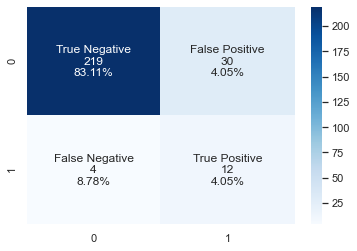

In [37]:
test_matrix = confusion_matrix(test_pca_target, y_pca_predict)

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     test_matrix.flatten()/np.sum(test_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [38]:
# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: ",accuracy_score(test_pca_target, y_pca_predict))

# Recall
from sklearn.metrics import recall_score
print("Recall: ",recall_score(test_pca_target, y_pca_predict, average=None)[0])

# Precision
from sklearn.metrics import precision_score
print("Precision: ",precision_score(test_pca_target, y_pca_predict, average=None)[0])

#F1-score
from sklearn.metrics import f1_score
print("F1 score: ",f1_score(test_pca_target, y_pca_predict, average=None)[0])

Accuracy:  0.8716216216216216
Recall:  0.9534883720930233
Precision:  0.9044117647058824
F1 score:  0.9283018867924528
